In [1]:
import torch
import torchvision
from torchvision import transforms 
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST

#downloading dataset
transform = transforms.ToTensor()

train_data = FashionMNIST(root='./FashionMNISTdataset', transform=transform, train=True, download=True)

test_data = FashionMNIST(root='./FashionMNISTdataset', transform=transform, train=False, download=True)

print(len(train_data))
print(len(test_data))

Processing...
Done!
60000
10000


In [2]:
#creating iterators
batch_size=32

train_data = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_data = DataLoader(test_data, shuffle=True, batch_size=batch_size)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


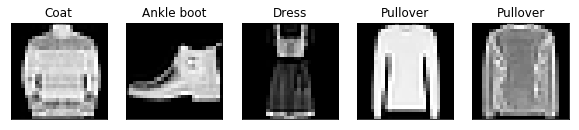

In [7]:
#visualizing some examples

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data = iter(train_data)
images, labels = next(data)
images = images.numpy()

fig = plt.figure(figsize=(10,10))

for i in range(5):
    ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[i]), cmap='gray')
    ax.set_title(classes[labels[i]])

In [15]:
#defing class

import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        #input is 28 i.e., w=28, f=5  out = (28-5)/1 + 1 =24 =>   32*24*24
        self.conv1 = nn.Conv2d(1, 32, 5)
        # input is 24 i.e., output = 32*12*12
        self.pool = nn.MaxPool2d(2,2)
        
        #input is 12 i.e., w=12, f=3 out = (12-3)/1 + 1 => 64*10*10
        self.conv2 = nn.Conv2d(32, 64, 3)
        # After max pooling output will be 64*5*5
        # after linear layer we want 10 output classes      
        self.fc = nn.Linear(64*5*5, 10)
        
    def forward(self, x):
        
        #First layer
        conv1 = self.conv1(x)
        activated1 = F.relu(conv1)
        pooled1 = self.pool(activated1)
        
        #Second Layer
        conv2 = self.conv2(pooled1)
        activated2 = F.relu(conv2)
        pooled2 = self.pool(activated2)
        
        #Third and last layer
        pooled2 = pooled2.view(pooled2.size(0), -1)
        linearOut = self.fc(pooled2)
        out = F.relu(linearOut)
        out = F.log_softmax(out, dim=1)
        
        return out
    
model = Model()
print(model)

Model(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc): Linear(in_features=1600, out_features=10, bias=True)
)


In [16]:
#optimizer and loss function

import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.01)

criterion = nn.NLLLoss()

In [17]:
#predicting accuracy before training 
correct_predictions = 0
total_predictions = 0

for images, labels in test_data:
    
    output = model(images)
    
    _, prediction = torch.max(output.data, 1)
    
    total_predictions += labels.size(0)
    correct_predictions += (prediction == labels).sum()
    
    
accuracy = 100 * correct_predictions.item()/total_predictions

print("Accuracy before training : ", accuracy)

Accuracy before training :  10.04


In [34]:
def train(n_epochs):
    
    total_loss = []
    for epoch in range(n_epochs):
        
        running_loss = 0
        
        for batch, data in enumerate(train_data):
                        
            images, labels = data
            
            optimizer.zero_grad()
            
            output = model(images)
            
            loss = criterion(output, labels)
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            
            if batch % 1000 == 999:
                avg_loss = running_loss/ 1000
                total_loss.append(avg_loss)
                print("Epoch : {0} Batch : {1}  Loss : {2}".format(epoch+1, batch+1, avg_loss))
                running_loss = 0.0
        
                
    print("Training completed")
    return total_loss

In [35]:
n_epochs = 5

loss = train(n_epochs)

Epoch : 1 Batch : 1000  Loss : 1.0204376384317875
Epoch : 2 Batch : 1000  Loss : 1.0049710682332516
Epoch : 3 Batch : 1000  Loss : 0.986609580039978
Epoch : 4 Batch : 1000  Loss : 0.9754127455353737
Epoch : 5 Batch : 1000  Loss : 0.9758928316831589
Training completed


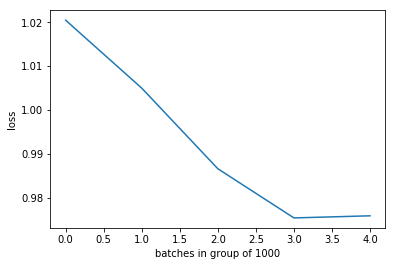

In [36]:
#visualising how the loss is decreased as the number of epochs are advanced
plt.plot(loss)
plt.xlabel("batches in group of 1000")
plt.ylabel("loss")
plt.show()

In [43]:
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for batch, data in enumerate(test_data):
    
    inputs, labels = data
    
    output = model(inputs)
    loss = criterion(output, labels)
    
    #getting average loss
    test_loss = test_loss + ((torch.ones(1) / (batch + 1)) * (loss.data - test_loss))
    
    _, predicted = torch.max(output.data, 1)
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    
print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))


  
    
    

Test Loss: 0.981971



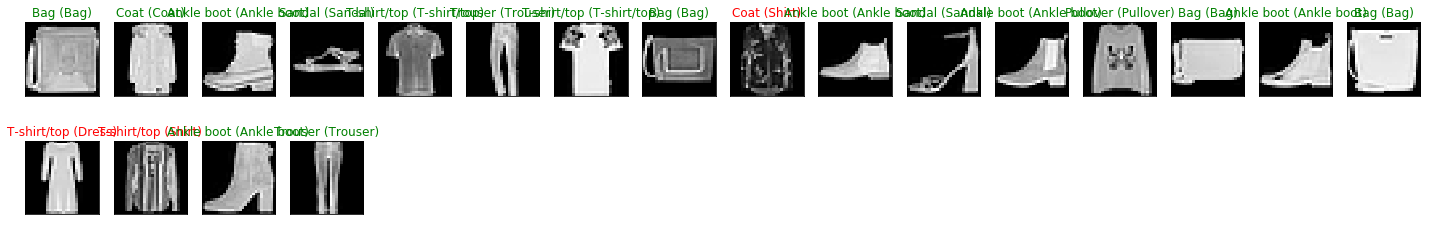

In [47]:
# one batch of test images
data = iter(test_data)
images, labels = next(data)

# getting  predictions
preds = np.squeeze(model(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

In [48]:
# Saving the model
model_dir = 'ModelFashionMNIST/'
model_name = 'fashionMNISTmodel.pt'

# after training, save your model parameters in the dir 'saved_models'
# when you're ready, un-comment the line below
torch.save(model.state_dict(), model_dir+model_name)